# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Soil hydraulics with Dumux-rosi


1. Infiltration into an initially dry soil

2. Evaporation from an initially moist soil 

3. Infiltration and evaporation from a multi-layered soil

4. Water uptake by a single root in 1D axisymmetric geometry

In [2]:
import os
sourcedir = os.getcwd()+"/../../../../"
import sys;  
sys.path.append(sourcedir+"dumux-rosi/python/modules");
sys.path.append(sourcedir+"dumux-rosi/build-cmake/cpp/python_binding/");
sys.path.append(sourcedir+"CPlantBox/src")  
import matplotlib.pyplot as plt  
import numpy as np  
 
from rosi_richards import RichardsSPnum  # C++ part (Dumux binding)
from rosi_richards import RichardsSP
from richards import RichardsWrapper  # Python part  
from rosi_richards_cyl import RichardsCylFoam  # C++ part (Dumux binding), macroscopic soil model
from richards_flat import RichardsFlatWrapper  # Python part of cylindrcial

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 397 nodes for 199 grid entities in 0.00056922 seconds.
Computed bounding box tree with 397 nodes for 199 grid entities in 6.0914e-05 seconds.
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.


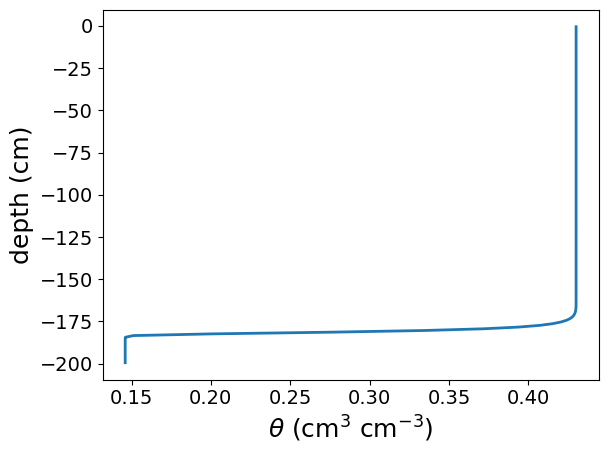

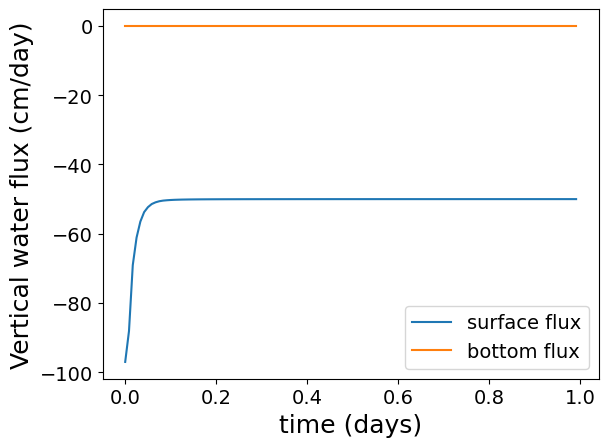

In [3]:
# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand = [0.045, 0.43, 0.15, 3, 1000]
loam = [0.08, 0.43, 0.04, 1.6, 50]
clay = [0.1, 0.4, 0.01, 1.1, 10]
soil = loam  # Select soil type for simulation  
# simulation time, days
sim_time = 1;  # |\label{l61i:simtime}|
dt = 720 / (24 * 3600)  # time step [days]   

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum()) 
s.initialize() 
s.setTopBC("atmospheric", 0.5, [[-1., 1.e10], [100., 100.]])  #  [cm/day] atmospheric is with surface run-off   |\label{l61i:top_bc}|
s.setBotBC("freeDrainage") 
N = 199
s.createGrid([-5., -5., -200.], [5., 5., 0.], [1, 1, N])  # [cm] N  
s.setHomogeneousIC(-400.)  # cm pressure head   
s.setVGParameters([soil])
s.initializeProblem()  
s.setCriticalPressure(-15000)  
s.ddt = 1.e-5  # initial dumux time step [days]  

top_ind = s.pick([0., 0., -0.5])  
bot_ind = s.pick([0., 0., -199.5]) 
top_new, bot_new, soil_times = [], [], []  

N = int(np.ceil(sim_time / dt)) 
for i in range(0, N):
    t = i * dt  # current simulation time   
    soil_times.append(t)  
    s.solve(dt)  
    velocities = s.getVelocities_()  
    top_new.append(velocities[top_ind])
    bot_new.append(velocities[bot_ind])  

top_new = np.array(top_new)  
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)  

# Extract and plot numerical solution  
points = s.getDofCoordinates()
theta = s.getWaterContent()
plt.figure(0)
plt.plot(theta, points[:, 2], linewidth = 2)
plt.xlabel(r'$\theta$ (cm$^3$ cm$^{-3}$)', fontsize = 18)
plt.ylabel('depth (cm)', fontsize = 18)
plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
plt.show()  

plt.figure(1)  
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('time (days)', fontsize = 18)
plt.ylabel('Vertical water flux (cm/day)', fontsize = 18)
plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.show()  


### Evaporation from an initially moist soil 

This example reproduces the evaporation example M2.2 from Schnepf et al. (2023). Water evaporated from the surface of an initially moist soil. Only the vertical water movement is considered. Atmospheric boundary conditions are set at the upper boundary and a free drainage boundary condition is set at the lower boundary. There is an analytical solution for this simple example, which can optionally be plotted for comparison.

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.0137e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 1.3986e-05 seconds.
initial water volume 1791.9056501866478


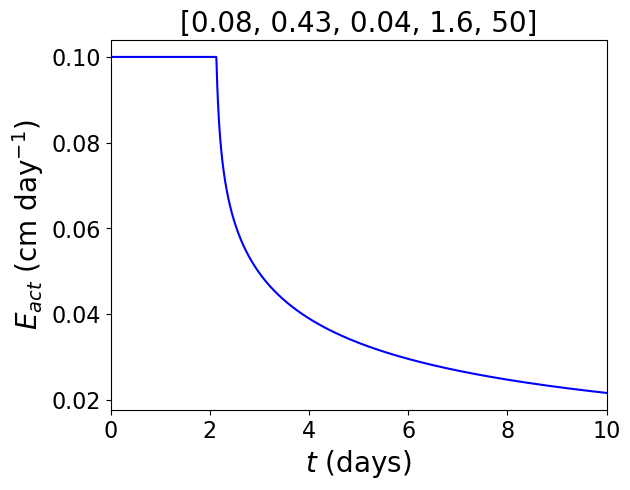

In [9]:
soil = loam  # Select soil type for simulation  
sim_time = 10;  
N = 2000
dt = sim_time / N  # time step [days]  
ic = -200  
evap = -0.1  # [cm/day]    

s = RichardsWrapper(RichardsSP())  
s.initialize()  
s.setTopBC("atmospheric", 0.5, [[0., 1.e10], [evap, evap]])  #  [cm/day] atmospheric is with surface run-off   
# s.setTopBC("flux", evap)  #  [cm/day]
# s.setTopBC("constantPressure", -10000)
s.setBotBC("freeDrainage")  # BC freeDrainage  
NZ = 100 # 1399
s.createGrid([-5., -5., -100.], [5., 5., 0.], [1, 1, NZ])  # [cm]  
# vols = (100. / NZ) * np.ones((NZ,)) * 100.  # cm3
s.setVGParameters([soil])  
s.setHomogeneousIC(ic)  # cm pressure head  
# s.setParameter("Problem.EnableGravity", "false")
s.initializeProblem()  
s.setCriticalPressure(-10000)  
s.setRegularisation(1.e-6, 0.)  
idx_top = s.pickCell([0.0, 0.0, 0.0])  # index to watch surface flux  
initial_water = s.getWaterVolume() 
print("initial water volume", initial_water)
s.ddt = 1.e-5  # initial Dumux time step [days] 
maxDt = 1.  # maximal Dumux time step [days]  

x_, y_ = [], []
for i in range(0, N):  
    s.solve(dt, maxDt)  
    f = s.getNeumann(idx_top)  # f = s.getSolutionHeadAt(idx_top)   
    #   current_water = s.getWaterVolume()
    #   f = (initial_water - current_water) / dt / 1.e2
    #   print(current_water, f)
    #   initial_water = current_water
    x_.append(s.simTime)
    y_.append(f)  

# Extract and plot numerical solution
plt.plot(x_, y_, 'b') 
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.xlim(0, 10)
plt.title(soil, fontsize = 20)
plt.xlabel('$t$ (days)', fontsize = 20)
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.show()  


### Infiltration and evaporation from a multi-layered soil

This example builds on the infiltration and evaporation problem M2.1 and M2.2 from Schnepf et al. (2023) and extends the simulation to a multi-layered soil profile at the Field Minirhizotron Facilities Selhausen (\url{https://www.fz-juelich.de/en/ibg/ibg-3/research-groups/modelling-terrestrial-systems/soil-root-systems-and-rhizosphere-processes/field-minirhizotron-facilities}).
The hydraulic properties of the soil profile are taken from Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}).
The Richards equations is solved to simulate water infiltration over 1 day into an initially dry soil followed by evaporation over 2 days. Only the vertical water movement is considered. A Neumann boundary condition is set at the upper boundary and a free drainage boundary condition is set at the lower boundary.

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 2379 nodes for 1190 grid entities in 0.000254197 seconds.
Computed bounding box tree with 2379 nodes for 1190 grid entities in 0.00022913 seconds.
***** external time step 0.05  d, simulation time 0.05000000000000001 d, internal time step 0.011842016709277366 d
***** external time step 0.05  d, simulation time 0.15000000000000002 d, internal time step 0.015716417441439656 d
***** external time step 0.05  d, simulation time 0.25000000000000006 d, internal time step 0.010708643337333752 d
***** external time step 0.05  d, simulation time 0.3500000000000001 d, internal time step 0.01309029693125586 d
***** external time step 0.05  d, simulation time 0.45000000000000007 d, internal time step 0.015447272190085189 d
***** external time step 0.05  d, simulation time 0.55 d, internal time step 0.009756362427691673 d
***** external time step 0.05  d, simulation time 0.6500000000000001 d, internal time st

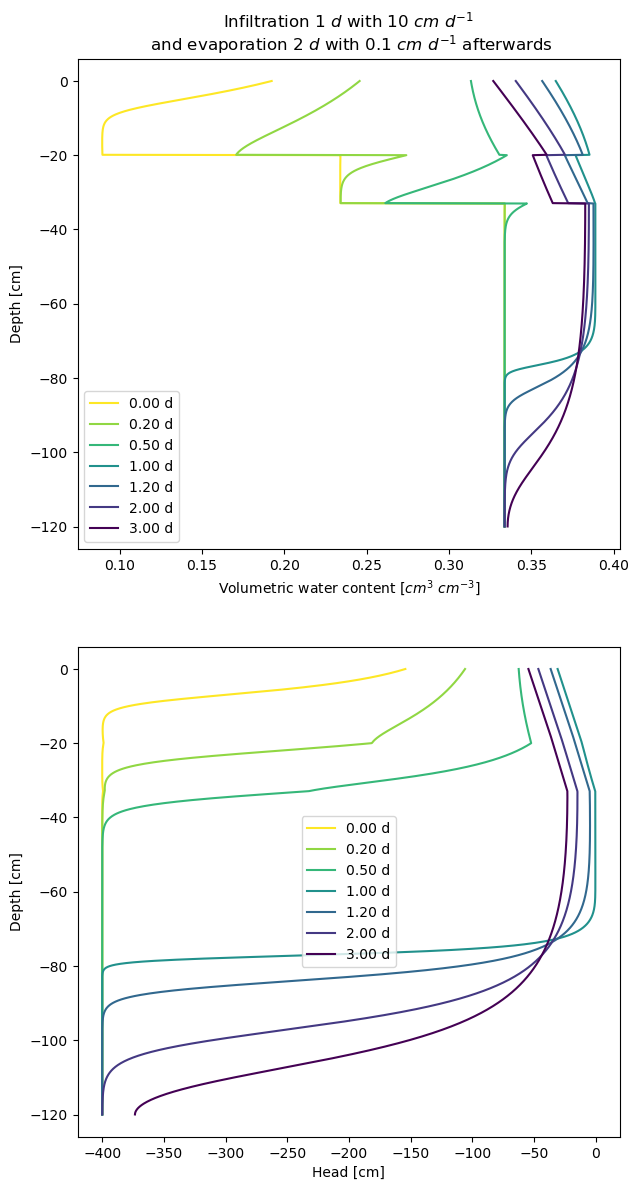

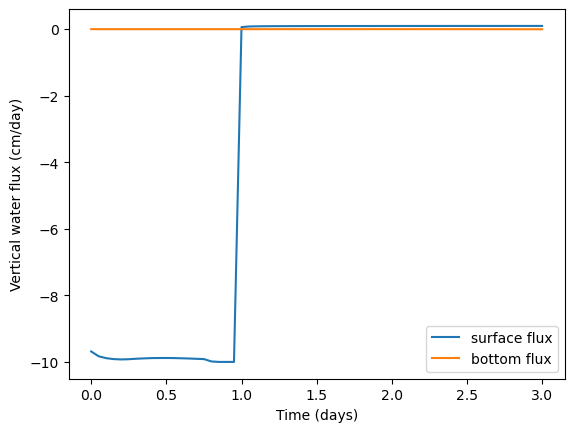

In [14]:
# Define Mualem van Genuchten parameters for Selhausen soil profile according to Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}) |\label{l61ies:genuchten_a}|
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
l1 = [0.008, 0.389, 0.012, 1.97, 91.68]  # 0-20 cm 
l2 = [0.008, 0.389, 0.023, 1.23, 63.36]  # 20-33 cm
l3 = [0.008, 0.389, 0.01, 1.1, 10]  # 33-57 cm
l4 = [0.008, 0.389, 0.01, 1.1, 10]  # 57-120 cm

soil = [l1, l2, l3, l4] # Combine the hydraulic conductivity vectors from all soil layers to define soil type for simulation  
sim_time = 3.05  #
dt = 0.05  # 720 / (24 * 3600)  # time step [days]

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum())  
s.initialize()  #
s.setTopBC("atmospheric", 0.5, [[0., 1., 1., 3., 1.e6], [10., 10., -0.1, -0.1, 0.]])  #  [cm/day] atmospheric is with surface run-off  
s.setBotBC("freeDrainage") 
N = 119 * 10  # use a fine grid resolution of 1 mm per grid point in z direction 
s.createGrid([-5., -5., -120.], [5., 5., 0.], [1, 1, N])  # [cm] N   
# define soil layers
layers_ID = [4, 4, 3, 3, 2, 2, 1, 1]  
layers_pos = [-120., -57., -57., -33., -33, -20, -20, 0] 
s.setLayersZ(layers_ID, layers_pos)
s.setHomogeneousIC(-400.)  # cm pressure head   
s.setVGParameters(soil) 
s.initializeProblem()  
s.setCriticalPressure(-15000)  
s.ddt = 1.e-5  # initial dumux time step [days]

top_ind = s.pick([0., 0., -0.5])
bot_ind = s.pick([0., 0., -119.5])  
top_new, bot_new, soil_times = [], [], []

N = int(np.ceil(sim_time / dt))  
z_, x_, h_ = [], [], []  # initialize solution vectors
for i in range(0, N):
    t = i * dt  # current simulation time
    soil_times.append(t)
    s.solve(dt)
    if i % 2 == 0:
        print("***** external time step", dt, " d, simulation time", s.simTime, "d, internal time step", s.ddt, "d")

    velocities = s.getVelocities_()
    top_new.append(velocities[top_ind])
    bot_new.append(velocities[bot_ind])

    points = s.getDofCoordinates()  # coordinates
    theta = s.getWaterContent()  # volumetric water content
    h = s.getSolutionHead()  # matric potential [cm]
    z_.append(points[:, 2])
    x_.append(theta)
    h_.append(h)

top_new = np.array(top_new)
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)

sel_idx = np.searchsorted(soil_times, [0., 0.2, 0.5, 1., 1.2, 2., 3.]) # define output times

# Plot solutions 
fig1, axs = plt.subplots(2, 1, figsize = (7, 14))
cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
cols = cmap(np.linspace(0, 1, len(sel_idx)))
cols = cols[::-1]
for ii, i in enumerate(sel_idx):
    axs[0].plot(x_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')
    axs[1].plot(h_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')

axs[0].set_title("Infiltration 1 $d$ with 10 $cm$ $d^{-1}$ \n and evaporation 2 $d$ with 0.1 $cm$ $d^{-1}$ afterwards")
axs[0].set_xlabel('Volumetric water content [$cm^{3}$ $cm^{-3}$]')
axs[0].set_ylabel('Depth [cm]')
axs[1].set_xlabel('Matric potential [cm]')
axs[1].set_ylabel('Depth [cm]')
axs[0].legend(loc = "best")
axs[1].legend(loc = "best")

plt.show()

plt.figure(1)
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('Time (days)')
plt.ylabel('Vertical water flux (cm/day)')
plt.legend()
plt.show()


### Water uptake by a single root in 1D axisymmetric geometry



area per cell [cm2] [[0.0014192 ]
 [0.00302198]
 [0.00643488]
 [0.01370219]
 [0.0291769 ]
 [0.06212813]
 [0.13229317]
 [0.28169983]
 [0.59984045]]
Distance from root surface [cm] [[0.02459233]
 [0.03588593]
 [0.05236593]
 [0.07641408]
 [0.11150593]
 [0.16271312]
 [0.23743632]
 [0.34647486]
 [0.50558748]]

domain water volume 2.4618629269006114 cm3/cm  =  0.0024618629269006114 l/cm
water content to water volume 2.4618629269006114 cm3/cm
0.0 days
0.041666666666666664 days
0.08333333333333333 days
0.125 days
0.16666666666666666 days
0.20833333333333331 days
0.25 days
0.29166666666666663 days
0.3333333333333333 days
0.375 days
0.41666666666666663 days
0.4583333333333333 days
0.5 days
0.5416666666666666 days
0.5833333333333333 days
0.625 days
0.6666666666666666 days
0.7083333333333333 days
0.75 days
0.7916666666666666 days
0.8333333333333333 days
0.875 days
0.9166666666666666 days
0.9583333333333333 days
1.0 days
1.0416666666666665 days
1.0833333333333333 days
1.125 days
1.1666666666666665 

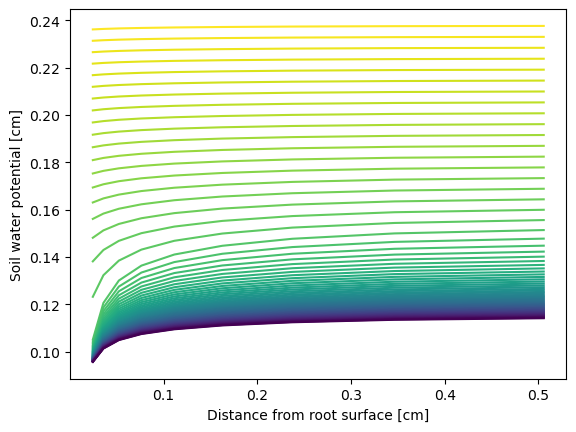

In [17]:
def sinusoidal(t):
    """ sinusoidal function (used for transpiration) (integral over one day is 1)"""
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


def plot_profile(cc, h, depth = -100.):
    """ shows soil matric potential profile over time"""
    fig, ax1 = plt.subplots()
    n = len(h) // 1
    cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
    cols = cmap(np.linspace(0, 1, n))
    cols = cols[::-1]
    for i in range(0, n):
        ax1.plot(cc, h[i * 1], color = cols[i])
    ax1.set_ylabel("Soil water potential [cm]")
    ax1.set_xlabel("Distance from root surface [cm]")


""" Soil """
s = RichardsFlatWrapper(RichardsCylFoam())  # water & single solute
logbase = 0.5
NC = 10  # [1] spatial resolution (1D model)
a_in = 0.02  # cm
a_out = 0.6  # cm
points = np.logspace(np.log(a_in) / np.log(logbase), np.log(a_out) / np.log(logbase), NC, base = logbase)
soil = [0.078, 0.43, 0.036, 1.56, 24.96]  # hydrus loam
s.initialize()
s.createGrid1d(points)
s.setVGParameters([soil])

""" Inital conditions """
s.setHomogeneousIC(-100.)  # [cm] homogeneous pressure head

""" Boundary conditions """
RS_Uptake_Wmax = 1.  # [cm/day]
s.setOuterBC("fluxCyl", 0.)  #  [cm/day] Neumann boundary condition
s.setInnerBC("fluxCyl", 0.)

""" Initialze problem """  # |\label{l63:init_start}|
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Newton.MaxAbsoluteResidual", "1.e-10")
s.setParameter("Newton.SatisfyResidualAndShiftCriterion", "True")
s.setParameter("Newton.EnableChop", "True")
s.initializeProblem()
wilting_point = -10000
s.setCriticalPressure(wilting_point)
s.ddt = 1e-4  # [day] initial Dumux time step

""" Simulation loop """
simtime = 3
dt = 3600. / (24.*3600)
cc = np.array(s.getCellCenters())  # [cm]
points = np.array(s.getPoints())  # [cm] cell faces
area = np.pi * (points[1:] ** 2 - points[:-1] ** 2)  # [cm2] area of each cell
print("area per cell [cm2]", area)
print("Distance from root surface [cm]", cc)
theta = np.array(s.getWaterContent())
volume0 = np.sum(np.multiply(theta , area))
print("\ndomain water volume", volume0, "cm3/cm  = ", volume0 / 1000, "l/cm")
print("water content to water volume", volume0 , "cm3/cm")

N = int(np.ceil(simtime / dt))
h, theta = [], []  # results

for i in range(0, N):
    t = i * dt  # current simulation time
    print(t, "days")

    s.setInnerBC("fluxCyl", -RS_Uptake_Wmax)  # [cm/day]; * sinusoidal(t)
    s.solve(dt)
    h.append(s.getSolutionHead())  # [cm]
    theta.append(s.getWaterContent())  # [1]

volumef = np.sum(np.multiply(theta[-1] , area))  # |\label{l63:vol}|
print("domain water volume", volumef, "cm3/cm  = ", volumef / 1000., "l/cm")  # |\label{l63:results}|
print("change in water volume", volumef - volume0, "cm3/cm = ", 1.e-3 * (volumef - volume0), "l/cm")

plot_profile(cc, theta)
plt.show()
